## General Package Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from convokit import Corpus, download
from tqdm import tqdm
import nltk

## Loading the Data

In [39]:
corpus = Corpus(filename=download("subreddit-Cornell"))

Dataset already exists at /Users/nickvick/.convokit/saved-corpora/subreddit-Cornell


# Lexical Analysis

## Lexical Analysis Package Imports and Set-Ups

In [40]:
import re
from wordfreq import zipf_frequency

# set up nltk tokenizers
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Lexical Helper Functions

In [41]:
def tokenize(text):
    '''Helper function to tokenize social media text. Note that the TweetTokenizer 
    preserves mentions, contractions'''
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    return tokens

In [42]:
def clean_lexical_tokens(tokens):
    '''Helper function to clean tokens by removing punctuation, numbers, and emojis
    for purely lexical analysis.'''

    cleaned = []

    for tok in tokens:
        # skip over punctuation
        if re.match(r'^\W+$', tok):
            continue
        # skip over emojis
        # if tok.encode()
        # only keep alphabetic tokens
        if tok.isalpha():
            cleaned.append(tok.lower())

    return cleaned

## Lexical Analysis Functions

In [43]:
def ttr(text):
    '''Function that returns the type-token ratio'''

    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)

    # error handling for when there are no tokens
    if len(tokens) == 0:
        return 0.0
    
    # recall that TTR is number of unique words / number of words
    num_types = len(set(tokens))
    num_tokens = len(tokens)
    ttr = num_types / num_tokens

    return ttr

In [44]:
def avg_word_length(text):
    '''Function that determines the average word length of a given text'''
    
    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)

    # error handling for when there are no tokens
    if len(tokens) == 0:
        return 0.0
    
    average_length = np.mean([len(word) for word in tokens])

    return average_length

In [45]:
# build aoa_dict: word -> average age of acquisition
aoa_df = pd.read_csv("Data/KupermanAoAData.csv")
aoa_dict = dict(zip(aoa_df["word"], aoa_df["rating_mean"]))

def aoa_score(text, aoa_dict):
    '''Returns the average age of acquisition score for a given text'''
    
    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)
    aoa_values = [aoa_dict[word] for word in tokens if word in aoa_dict]

    # if there are no words, return a default value
    if len(aoa_values) == 0:
        return np.nan
    
    aoa_score = np.mean(aoa_values)

    return aoa_score

In [46]:
def zipf_score(text):
    '''Returns a frequency score (higher -> more frequent) based on the Zipf scale'''
    
    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)
    
    zipf_values = [zipf_frequency(word, 'en') for word in tokens]

     # if there are no words, return a default value
    if len(zipf_values) == 0:
        return np.nan

    zipf_score = np.mean(zipf_values)

    return zipf_score

# Syntactic Analysis

## Syntactic Analysis Package Imports and Set-Ups

In [47]:
from nltk import pos_tag
from nltk.corpus import treebank
from nltk.tree import *
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('treebank')

import spacy
nlp = spacy.load("en_core_web_sm") # pre-trained English model

import stanza
stanza.download("en")
stanza_parser = stanza.Pipeline("en", processors="tokenize,pos,constituency")

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
2025-12-07 14:13:57 INFO: Downloaded file to /Users/nickvick/stanza_resources/resources.json
2025-12-07 14:13:57 INFO: Downloading default packages for language: en (English) ...
2025-12-07 14:13:58 INFO: File exists: /Users/nickvick/stanza_resources/en/default.zip
2025-12-07 14:13:59 INFO: Finished downloading models and saved to /Users/nickvick/stanza_resources
2025-12-07 14:13:59 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-12-07 14:13:59 INFO: Downloaded file to /Users/nickvick/stanza_resources/resources.json
2025-12-07 14:13:59 WARNING: Language en package default expects mwt, which has been added
2025-12-07 14:13:59 INFO: Loading these models for language: en (English):
| Processor    | P

## Syntactic Helper Functions

In [48]:
def split_sentences(text):
    '''Helper function to split a given post into separate sentences'''

    sentence_tokens = sent_tokenize(text)

    return sentence_tokens

In [49]:
# define relevant sets of tags and words
FINITE_VERB_TAGS = {"VB", "VBD", "VBN", "VBP", "VBZ"}
SUBJECT_TAGS = {"NN", "NNS", "NNP", "NNPS", "PRP"}
SUBORDINATING_CONJ = {"IN"} # tag for subordinating conjunction
COORDINATING_CONJ = {"CC"} # tag for coordinating conjunction

PUNCT = '?!.({[]})-–—"\''
CLOSING_PUNCT = '.!?…'
TRAILING_CLOSERS = set(['"', "'", ')', ']', '}', '”', '’'])

# normalize curly quotes and fancy punctuation
FANCY_TO_ASCII = {
                '“': '"', '”': '"',
                '‘': "'", '’': "'",
                '—': '-', '–': '-',
                '…': '...'
                }

In [50]:
def is_complete_sentence(sentence):
    '''Helper function to determine whether a sentence is complete. Recall that a complete sentence follows these rules:
    -contains at least one subject 
    -contains at least one finite verb
    -ends with appropriate punctuation (.?!) 
    -if it begins with a subordinator, has an independent clause after
    -does not end with a conjunction
    '''

    cleaned = sentence.strip() # removing trailing/leading whitespace
    # account for differences in straight vs. smart quotes
    for f, a in FANCY_TO_ASCII.items():
        cleaned = cleaned.replace(f, a)
    # remove leading/trailing quotes
    cleaned = cleaned.strip('\"')
    cleaned = cleaned.strip('\'')

    # empty string
    if not cleaned:
        return False
    
    # tokenize sentence and tag tokens
    tokens = tokenize(cleaned)
    tags = pos_tag(tokens)

    # ensure length is appropriate
    if len(tokens) < 2:
        return False

    # first letter should be capital
    j = 0
    while j < len(cleaned) and cleaned[j] in PUNCT:
        j += 1
    if j >= len(cleaned):
        return False
    if not cleaned[j].isalpha() or not cleaned[j].isupper():
        return False
        
    # last relevant char must end with proper punctuation
    i = len(cleaned) - 1
    while i > 0 and cleaned[i] in TRAILING_CLOSERS:
        i -= 1
    if i <= 0 or cleaned[i] not in CLOSING_PUNCT:
        return False
    
    # find the first words tag
    first_word = None
    first_tag = None
    for word, tag in tags:
        if word.isalpha():
            first_word = word
            first_tag = tag
            break
    # if first word is subordinating conjunction (including "when"), need independent clause after
    if first_tag in SUBORDINATING_CONJ or first_word == "When":
        if ',' in tokens: # indepdent clause will start after a comma
            comma_index = tokens.index(',')
            post_sub_tags = tags[comma_index+1:]
            # check if independent clause is a complete thought
            has_finite_verb_post_sub = any(tag in FINITE_VERB_TAGS for _, tag in post_sub_tags)
            has_subject_post_sub = any(tag in SUBJECT_TAGS for _, tag in tags)
            if not (has_finite_verb_post_sub and has_subject_post_sub):
                return False
        # if no comma separating clauses
        else:
            noun_count = sum(1 for _, tag in tags if tag in SUBJECT_TAGS)
            verb_count = sum(1 for _, tag in tags if tag in FINITE_VERB_TAGS)
            # edge case for when first word is if
            if first_word == "If" and verb_count < 2:
                return False
            # check for two nouns, if not assume fragment
            if noun_count < 2:
                return False

    # find the last words tag
    last_tag = None
    for word, tag in reversed(tags):
        if word.isalpha():
            last_tag = tag
            break
    # last word cannot be conjunction
    if last_tag in COORDINATING_CONJ:
        return False

    # check if it has finite verb and subject
    has_finite_verb = any(tag in FINITE_VERB_TAGS for _, tag in tags)
    has_subject = any(tag in SUBJECT_TAGS for _, tag in tags)

    return has_finite_verb and has_subject

In [51]:
def create_nltk_tree(sentence):
    '''Helper function to create a tree for a valid sentence'''

    '''if not is_complete_sentence(sentence):
        raise ValueError("Sentence is not complete")'''
    
    doc = stanza_parser(sentence)
    stanza_tree = doc.sentences[0].constituency
    nltk_tree = Tree.fromstring(str(stanza_tree))
    
    return nltk_tree

## Syntactic Analysis Functions

In [52]:
def fragment_ratio(text):
    '''Function to determine the ratio of fragments to lines in a given text'''

    sentences = split_sentences(text)
    total = len(sentences)

    if total == 0:
        return None

    # add complete sentences to a list
    is_complete = []
    for sent in sentences:
        if is_complete_sentence(sent):
            is_complete.append(sent)

    num_fragment = total - len(is_complete)

    fragment_ratio = num_fragment/total

    return fragment_ratio

In [53]:
def avg_tree_depth(text):
    '''Function to compute the average depth of the parse tree representing each sentence.
    Note that .height() accounts for the leaf level, which is not a true extra layer.'''

    sentences = split_sentences(text)

    # for each sentence/fragment, compute the tree height/depth
    depths = []
    for sent in sentences:
        tree = create_nltk_tree(sent)
        depths.append(tree.height()-1)

    avg_tree_depth = np.mean(depths)
    
    return avg_tree_depth

# Example Analysis

In [54]:
N = 100000 # number of utterances to start with

# collect utterances into a list
utterances_data = []
for utt in corpus.iter_utterances():
    if hasattr(utt, "timestamp") and utt.text:
        utterances_data.append({
            "id": utt.id,
            "text": utt.text,
            "timestamp": utt.timestamp
        })

df = pd.DataFrame(utterances_data) # convert list to dataframe for easier access
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # convert Reddit timestamps to datetime
df = df.sort_values('timestamp').reset_index(drop=True)
# df = df.head(N)

ttrs, avg_lengths, aoas, zipfs, frag_ratios, tree_depths = [], [], [], [], [], []
# loop through dataframe and display progress
for text in tqdm(df['text'], desc="Computing lexical measures"):
    ttrs.append(ttr(text))
    avg_lengths.append(avg_word_length(text))
    aoas.append(aoa_score(text, aoa_dict))
    zipfs.append(zipf_score(text))

for text in tqdm(df['text'], desc="Computing syntactic measures"):
    frag_ratios.append(fragment_ratio(text))
    tree_depths.append(avg_tree_depth(text))

# add metrics to dataframe
df['ttr'] = ttrs
df['avg_word_length'] = avg_lengths
df['aoa_score'] = aoas
df['zipf_score'] = zipfs

df['frag_ratio'] = frag_ratios
df['avg_tree_depth'] = tree_depths

# aggregate metrics by month
df.set_index('timestamp', inplace=True)
numeric_cols = ['ttr', 'avg_word_length', 'aoa_score', 'zipf_score', 'frag_ratio', 'avg_tree_depth']
monthly_metrics = df[numeric_cols].resample('M').mean()

Computing syntactic measures:  14%|█▎        | 9879/72987 [48:18<3:32:06,  4.96it/s] /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Computing syntactic measures: 100%|██████████| 72987/72987 [5:54:46<00:00,  3.43it/s]   
/var/folders/dj/6y_wgvgs5m59w08whyk9sjp80000gn/T/ipykernel_75427/3036398934.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_metrics = df[numeric_cols].resample('M').mean()


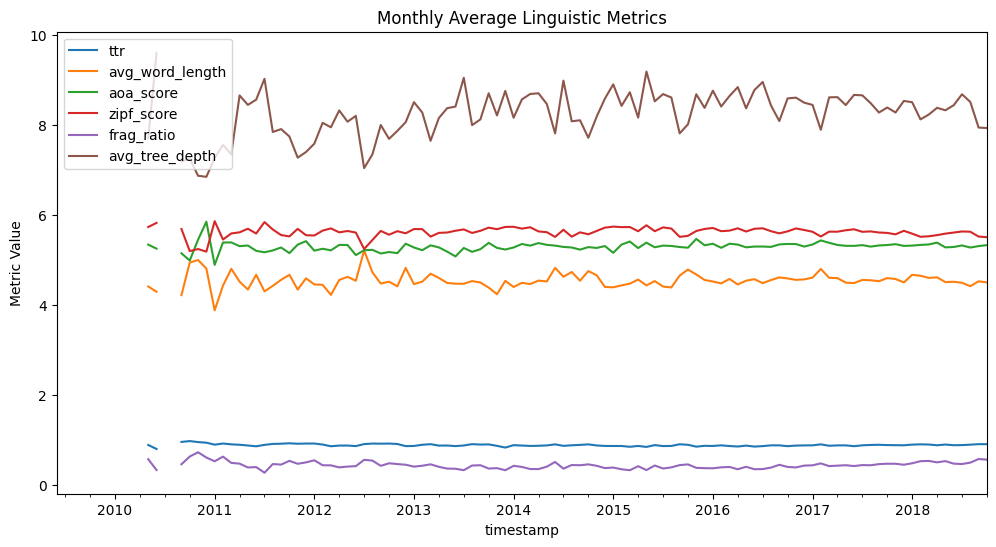

In [55]:
monthly_metrics.plot(figsize=(12,6), title='Monthly Average Linguistic Metrics')
plt.ylabel('Metric Value')
plt.show()

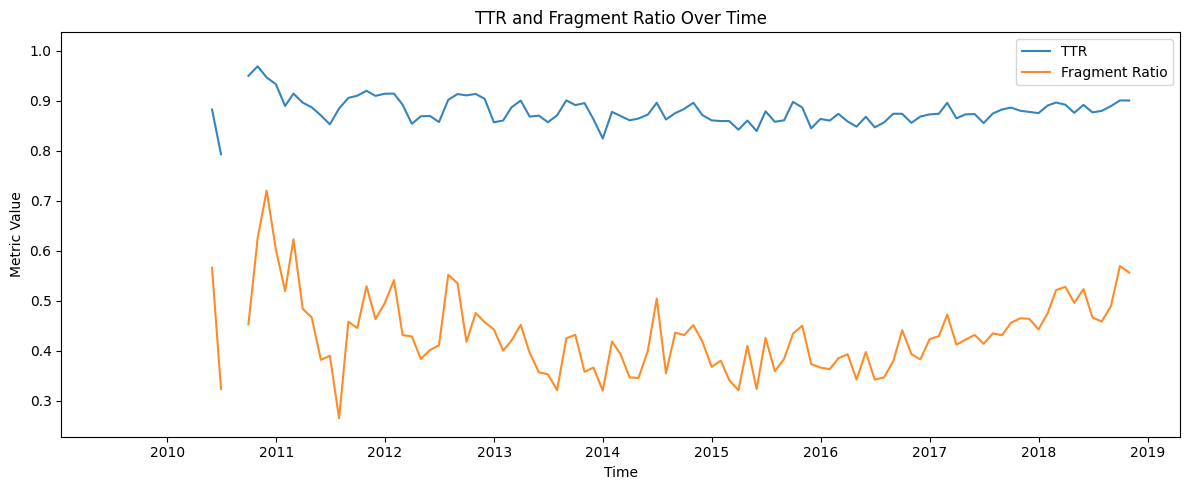

In [60]:
plt.figure(figsize=(12, 5))

plt.plot(monthly_metrics.index, monthly_metrics['ttr'], label='TTR', alpha=0.9)
plt.plot(monthly_metrics.index, monthly_metrics['frag_ratio'], label='Fragment Ratio', alpha=0.9)

plt.title('TTR and Fragment Ratio Over Time')
plt.xlabel('Time')
plt.ylabel('Metric Value')
plt.legend()
plt.tight_layout()
plt.show()

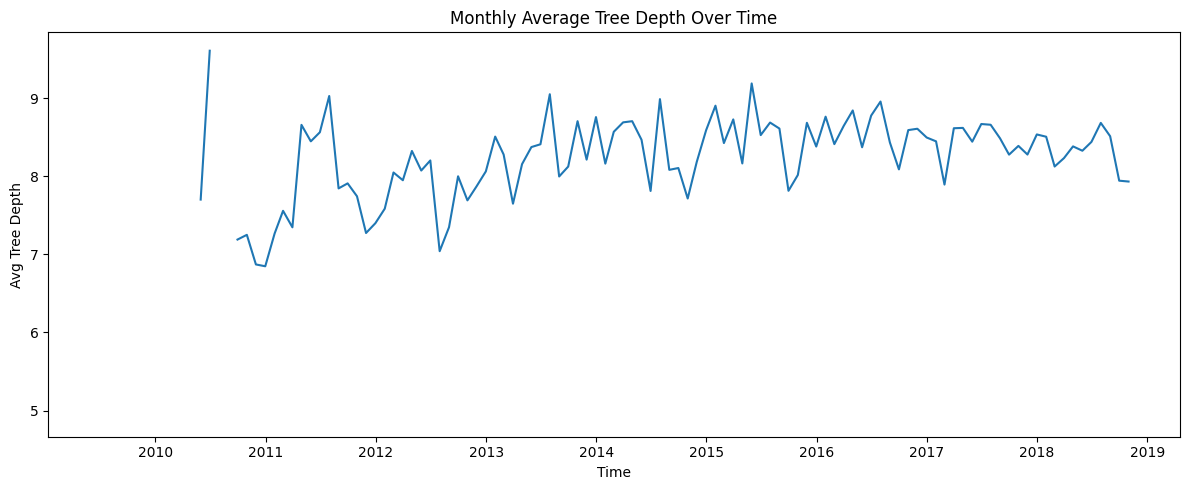

In [57]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_metrics.index, monthly_metrics['avg_tree_depth'], label='Average Tree Depth')
plt.title('Monthly Average Tree Depth Over Time')
plt.xlabel('Time')
plt.ylabel('Avg Tree Depth')
plt.tight_layout()
plt.show()

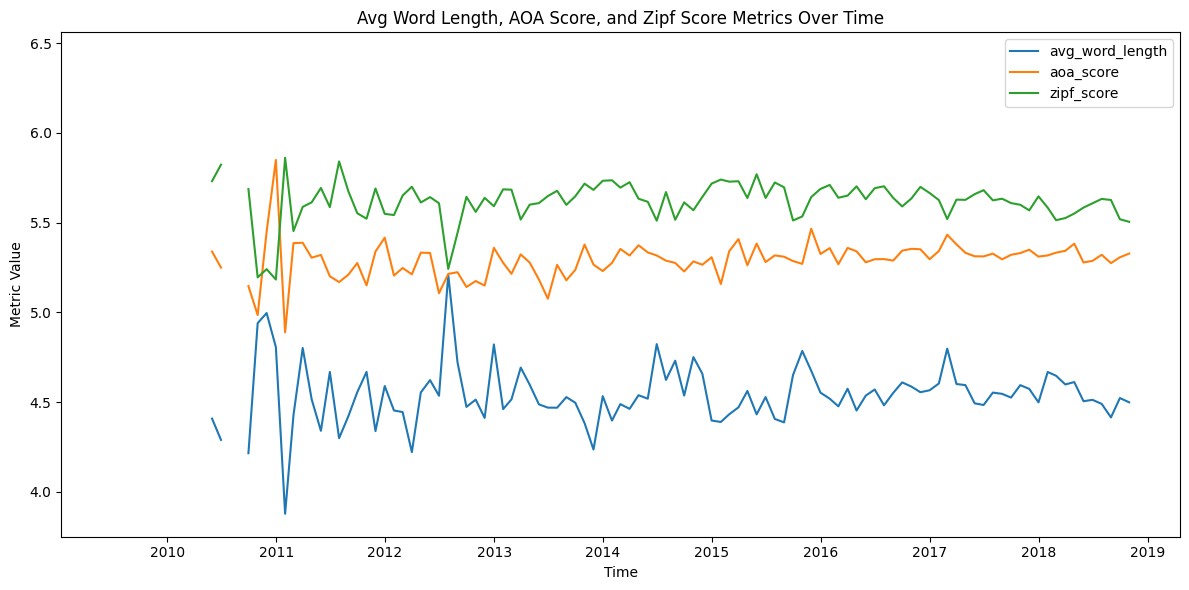

In [64]:
metrics_to_plot = ['avg_word_length', 'aoa_score', 'zipf_score']

plt.figure(figsize=(12, 6))
for col in metrics_to_plot:
    plt.plot(monthly_metrics.index, monthly_metrics[col], label=col)

plt.title('Avg Word Length, AOA Score, and Zipf Score Metrics Over Time')
plt.xlabel('Time')
plt.ylabel('Metric Value')
plt.legend()
plt.tight_layout()
plt.show()